In [3]:
import sys
sys.path.append('/notebooks')
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [5]:
torch.cuda.is_available()

True

In [6]:
import pandas as pd

In [7]:
import os as os 
from os import * 
import random 

In [20]:
PATH = '/data/plant_seedlings/'
sz = 224
arch=resnet50
bs = 58

In [9]:
classes=!ls {PATH}train
classes

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']

In [14]:
from glob2 import glob
import pandas as pd

label_df = pd.DataFrame(columns=["file", "species"])

for image in glob("{}/train/**/*.png".format(PATH)):
    dir_ = image.split('/')
    file_, species = dir_[-1], dir_[-2]

    label_df = label_df.append({
        "file": file_,
        "species": species
        }, ignore_index=True)

label_df.to_csv('/data/plant_seedlings/labels.csv', index=False)

In [15]:
label_df.head()

,file,species
0,0bec204c7.png,Cleavers
1,d8597aa6a.png,Cleavers
2,7e8212b65.png,Cleavers
3,58b68b1ea.png,Cleavers
4,ef4a36963.png,Cleavers


In [16]:
label_df.pivot_table(index = 'species',aggfunc = len).sort_values('file',ascending = False)

,file
species,
Loose Silky-bent,654
Common Chickweed,611
Scentless Mayweed,516
Small-flowered Cranesbill,496
Fat Hen,475
Charlock,390
Sugar beet,385
Cleavers,287
Black-grass,263


At this stage, move all images to train folder and delete subfolders.

In [17]:
#get validation indexes
n = len(label_df)-1 
val_idxs = get_cv_idxs(n)

In [21]:
#take transforms
tfms = tfms_from_model(arch,sz,aug_tfms = transforms_side_on, max_zoom = 1.1)
data = ImageClassifierData.from_csv(PATH, folder = 'train', csv_fname = f'{PATH}/labels.csv',
                                    test_name='test', val_idxs = val_idxs,  tfms = tfms, bs = bs)

In [24]:
fn = '/data/plant_seedlings/'+data.trn_ds.fnames[12]; fn

'/data/plant_seedlings/train/8c26d810d.png'

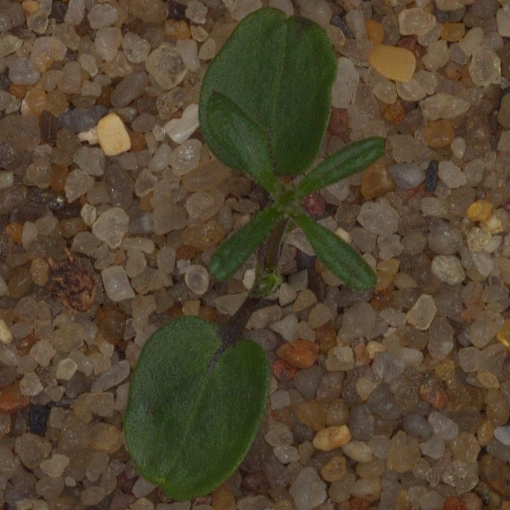

In [25]:
img = PIL.Image.open(fn); img

In [26]:
img.size

(510, 510)

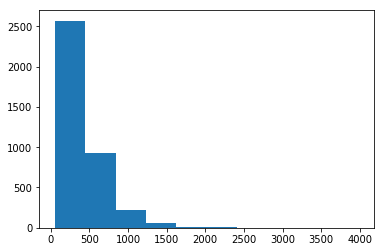

In [31]:
size_d = {k: PIL.Image.open(PATH+'/'+k).size for k in data.trn_ds.fnames}
row_sz, col_sz = list(zip(*size_d.values()))
row_sz=np.array(row_sz); col_sz=np.array(col_sz)
plt.hist(row_sz);

**Initial Model**

In [32]:
def get_data(sz,bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, folder = 'train', csv_fname = f'{PATH}/labels.csv', 
                                        tfms=tfms, val_idxs=val_idxs, bs = bs,
                                        test_name='test')
    return data if sz>300 else data.resize(340,'tmp')

In [33]:
data = get_data(sz,bs)

In [39]:
learn = ConvLearner.pretrained(arch,data,precompute=True)

In [40]:
lrf=learn.lr_find()

epoch      trn_loss   val_loss   <lambda>   
    0      0.634108   1.288981   0.876269  



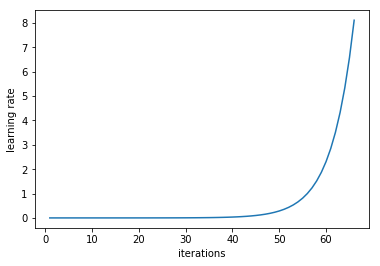

In [41]:
learn.sched.plot_lr()

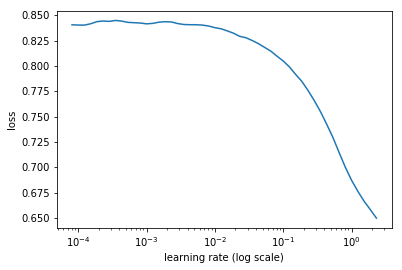

In [42]:
learn.sched.plot()

In [43]:
learn.fit(1e-1,3)

epoch      trn_loss   val_loss   <lambda>   
    0      0.311275   0.164304   0.933781  
    1      0.185271   0.124004   0.952582  
    2      0.14106    0.107861   0.960402  



[array([0.10786]), 0.9604015372952621]

**Data Augmentation**

In [45]:
data = get_data(sz,bs)

In [46]:
learn = ConvLearner.pretrained(arch,data,precompute = True, ps = 0.5)

In [47]:
learn.fit(0.1,3)

epoch      trn_loss   val_loss   <lambda>   
    0      0.326283   0.168487   0.931673  
    1      0.198073   0.12983    0.950973  
    2      0.153711   0.116704   0.956852  



[array([0.1167]), 0.9568520888010996]

In [48]:
learn.precompute = False

In [49]:
learn.fit(1e-1, 2, cycle_len = 1)

epoch      trn_loss   val_loss   <lambda>   
    0      0.131824   0.104363   0.961899  
    1      0.124637   0.100646   0.962287  



[array([0.10065]), 0.9622871775270387]

In [50]:
log_preds,y = learn.TTA(is_test = True)

In [51]:
probs = np.exp(log_preds)
probs.shape

(5, 794, 19)

In [54]:
predictions = log_preds[0]
data.classes
preds = np.argmax(predictions, axis=1)
preds_classes = [data.classes[i] for i in preds]
submission = pd.DataFrame(preds_classes, os.listdir(f'{PATH}test'))
submission.to_csv('plant_seedlings_kaggle_submission.csv')